# Tanzania Waterpoint Functionality Classification

<img src="Water-Stressed-Countries.jpg" alt="Cover Photo" width="1000" height="100" align="center" />

## Tanzania's water and sanitation crisis

Tanzania faces a water and sanitation crisis that affects its population of 59 million. About 28% of this population, around 16 million people, lack access to safe water. Additionally, a substantial 73%, or approximately 44 million people, lack access to properly managed household sanitation facilities. These conditions result in significant challenges, especially for women and girls who spend extended periods fetching water over long distances. Challenges include insufficient funding for planned government initiatives, population growth, and the impact of climate change, leading to extreme weather events. These difficulties are particularly burdensome for those living in poverty. Ensuring safe water access, especially within homes, is now more critical than ever for families across Tanzania.

# Objective

## Predict which water pumps are faulty to promote access to clean, potable water across Tanzania

In [1]:
#Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')


#Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn import set_config  #For PipeLine Diagram Display


#Model Buidling 
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import classification_report,accuracy_score,roc_auc_score,confusion_matrix
from sklearn.utils.validation import check_is_fitted
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

#For the nearest city finder
from geopy.geocoders import Nominatim
from geopy.distance import geodesic

sns.set_style('whitegrid')
%matplotlib inline
pd.set_option("display.max_columns",100)
set_config(display = 'diagram')

**NOTE**:
- **As Data Source refered Water Pumps as "Wells".We will do the same to avoid confusion.**

In [2]:
X = pd.read_csv('4910797b-ee55-40a7-8668-10efd5c1b960.csv')
y = pd.read_csv('0bf8bc6e-30d0-4c50-956a-603fc693d966.csv')

In [3]:
y.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [4]:
final_test = pd.read_csv('702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv')

In [5]:
X.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

**For the Further Column Description Please Click [here](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/)**

In [6]:
X.shape

(59400, 40)

In [7]:
X.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [8]:
y.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [9]:
final_test.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,NaN,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,VWC,NaN,True,1987,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,Water Board,BRUDER,True,2000,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [10]:
# Concat the X and Y for one Master DataFrame
df = pd.concat([X,y],axis = 1)

#Dropping 'id' Column
df.drop('id',axis = 1,inplace= True)

#Dropping Duplicates
df.drop_duplicates(keep ='first',inplace = True)
data = df.copy()

In [11]:
data.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59364 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59364 non-null  float64
 1   date_recorded          59364 non-null  object 
 2   funder                 55729 non-null  object 
 3   gps_height             59364 non-null  int64  
 4   installer              55709 non-null  object 
 5   longitude              59364 non-null  float64
 6   latitude               59364 non-null  float64
 7   wpt_name               59364 non-null  object 
 8   num_private            59364 non-null  int64  
 9   basin                  59364 non-null  object 
 10  subvillage             58993 non-null  object 
 11  region                 59364 non-null  object 
 12  region_code            59364 non-null  int64  
 13  district_code          59364 non-null  int64  
 14  lga                    59364 non-null  object 
 15  wa

#### Data Imbalance Check

In [13]:
df['status_group'].value_counts(normalize = True)

functional                 0.54304
non functional             0.38429
functional needs repair    0.07267
Name: status_group, dtype: float64

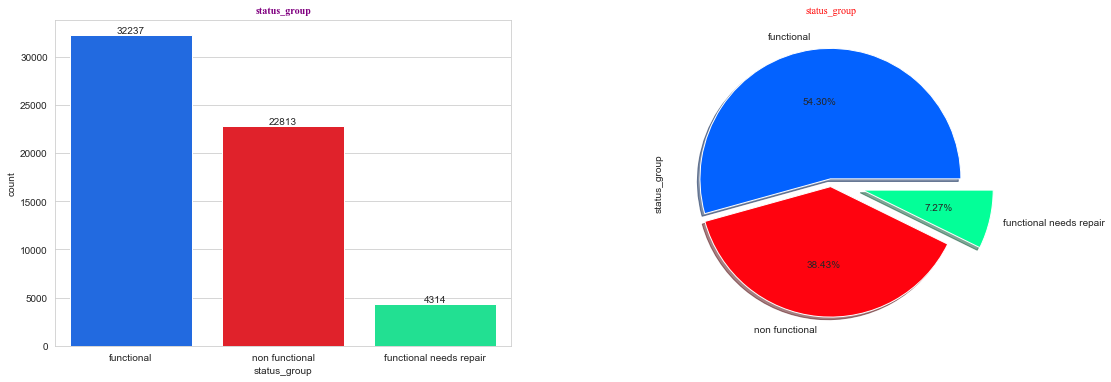

In [14]:
#CountPlot for Count
palette = ['#0362FF','#FF030F','#03FF98']
ax = plt.figure(figsize=(18,6))
ax = plt.subplot(1,2,1)
ax = sns.countplot(x='status_group', data=df,palette=palette)
ax.bar_label(ax.containers[0])
plt.title("status_group", fontsize=20,color='purple',font='Times New Roman',fontweight = 'bold')


#Pie Chart for Percentage
ax =plt.subplot(1,2,2)
ax=df['status_group'].value_counts()
ax.plot.pie(explode=[0.03,0.03,0.25],autopct='%1.2f%%',shadow=True,colors = palette);
plt.title(label = "status_group", fontsize = 20,color='Red',font='Times New Roman');
plt.show()

- The dataset comprises 59,364 rows and 40 columns, including the target variable labeled as 'status group'.


- It's crucial to address any data imbalances during subsequent modeling. In our case, the data distribution reveals that 'functional' accounts for 54.30%, 'non-functional' for 38.43%, and 'functional needs repair' for only 7.27%.

In [15]:
df['latitude'].describe()

count    5.936400e+04
mean    -5.709463e+00
std      2.943608e+00
min     -1.164944e+01
25%     -8.541904e+00
50%     -5.023822e+00
75%     -3.326918e+00
max     -2.000000e-08
Name: latitude, dtype: float64

In [16]:
df.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59364.000000,59364.000000,59364.000000,5.936400e+04,59364.000000,59364.000000,59364.000000,59364.000000,59364.000000
mean,317.843017,668.702513,34.097560,-5.709463e+00,0.474429,15.295516,5.631494,180.019086,1301.441227
std,2998.473133,693.131013,6.517065,2.943608e+00,12.239934,17.592619,9.636138,471.604294,951.369704
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.095187,-8.541904e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,370.000000,34.910318,-5.023822e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1320.000000,37.179490,-3.326918e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


As per the given data description, a minimum longitude value of zero is established, aligning with the Prime Meridian. This meridian runs through specific African countries: Algeria, Mali, Burkina Faso, Togo, and Ghana.
- Tanzania, located in Africa with coordinates around 6.3690° S latitude and 34.8888° E longitude, has longitudes ranging from 29 to 40. Any longitude values lower than 28 degrees for Tanzania would likely be considered as missing values.
- *For more information, click* [*here*](https://www.mapsofworld.com/lat_long/tanzania-lat-long.html).

## EDA

#### Univariate Analysis

#### Latitude and Longitude

In [17]:
def uni_analysis(col,title):
    sns.set_context("paper")
    plt.figure(figsize=(7,4))
    sns.distplot(df[col],color = 'red')
    plt.title(title)
    plt.show();

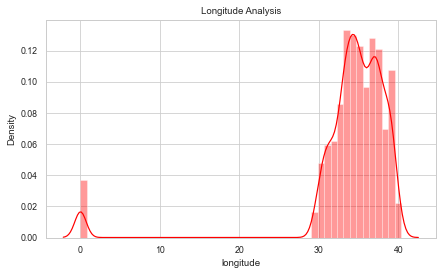

In [18]:
uni_analysis('longitude',"Longitude Analysis")

- The frequency of data points along the Prime Meridian is quite low, making it more practical to exclude them.As these low quantity will not affect our analysis

In [19]:
len(df[df['longitude'] ==0])

1777

In [20]:
#Replacing the Zero with Null Values and Then Dropping Them

df['longitude'] = df['longitude'].replace(0, np.nan)
df.dropna(subset=['longitude'], inplace=True)

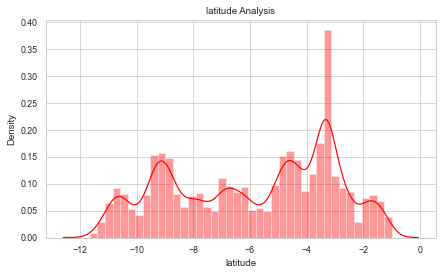

In [21]:
uni_analysis('latitude',"latitude Analysis")

In practice, the latitude values in Tanzania span from 1 to 12, which is evident from the analysis of the chart.

**amount_tsh**

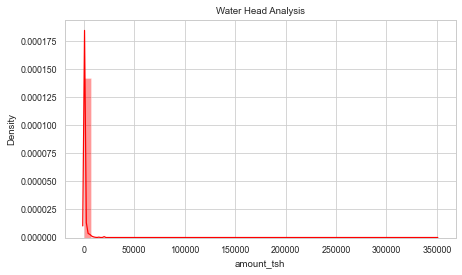

In [22]:
uni_analysis('amount_tsh',"Water Head Analysis")

In [23]:
len(df[df['amount_tsh']==0])

39826

In [24]:
df[df['amount_tsh']==0]['status_group'].value_counts(normalize = True)

functional                 0.472932
non functional             0.460227
functional needs repair    0.066841
Name: status_group, dtype: float64

- Roughly 70% of the 'amount_tsh' values are zero, while the remaining values are distributed thinly across the range of above 0 to 3,500,000.
- 'amount_tsh' refers to the total static head, representing the available water quantity at a waterpoint.


- When analyzing the value counts of the target variable, an interesting observation emerges: **about 47% of wells with a zero head are categorized as functional**. This observation contradicts practical expectations, raising concerns about the reliability of this independent variable for accurate model predictions.

#### Well Altitude

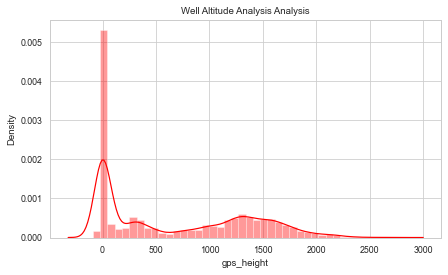

In [25]:
# gps_height is describes as a Well Altitude
uni_analysis('gps_height',"Well Altitude Analysis Analysis")

In [26]:
print("No of the Wells On the Benchmark :",len(df[df['gps_height'] ==0]))
print("No of the Wells Above Benchmark :",len(df[df['gps_height'] >0]))
print("No of the Wells Below Benchmark :",len(df[df['gps_height'] <0]))

No of the Wells On the Benchmark : 18625
No of the Wells Above Benchmark : 37466
No of the Wells Below Benchmark : 1496


- Tanzania Lowest Point : 0m (Indian Ocean)
- Tanzania highest point : 5,895m (Mount KiliManjaro)


- Well Altitude zero is taken at Sea Level which expains Well Altidude as 1000 and Above.
-  As Analysed almost 33% of well altitude is 0 which also the mode of gps_height.**Negative values of Well Altitudes that the well in some areas are below Sea Level and Deep Underground.** 
- Above Analysis about Benchmark can change given further Analysis.

#### Num_Private

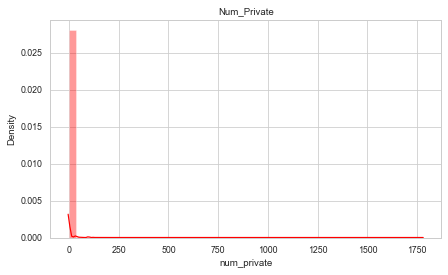

In [27]:
uni_analysis('num_private',"Num_Private")

In [28]:
print("Percent of Zero Num_Private :",len(df[df['num_private']==0])/len(df))

Percent of Zero Num_Private : 0.9868546720614028


- The data source lacks any description of the 'Num Private' feature. Approximately 99% of its values are 0, mirroring the distribution of the 'amount_tsh' feature.
- Due to its highly imbalanced nature,limited variance and lack of information about it, makes it reliability for predictive modeling very less.

#### Population

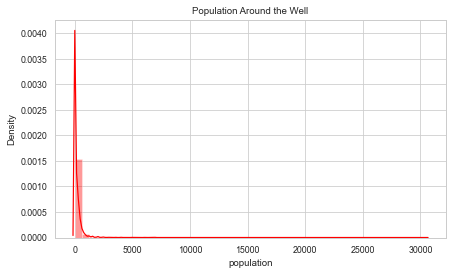

In [29]:
uni_analysis('population',"Population Around the Well")

In [30]:
print("No of Well with No Population Around:",len(df[df['population']==0]))
print("Percent of Well with Zero Population :",len(df[df['population']==0])/len(df))

No of Well with No Population Around: 19568
Percent of Well with Zero Population : 0.3397989129491031


<Axes: xlabel='population', ylabel='Density'>

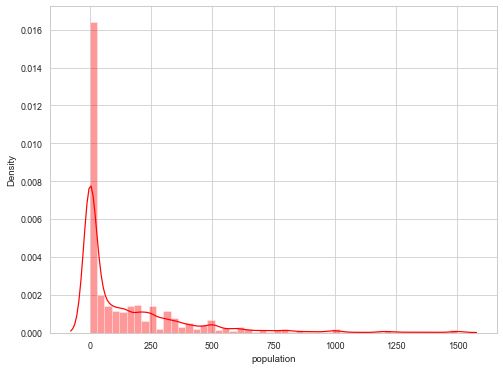

In [31]:
plt.figure(figsize = (8,6))

filtered_population = df.loc[df['population'] <= 1500, 'population']

sns.distplot(filtered_population,color = 'red')

- About 34% of the wells have a population of zero in their vicinity. The population residing around these wells tends to be relatively small, with a majority having fewer than 1500 residents.

- The large portions of Zeroes in most of the features will be challenging for the model predictions and can be point towards missing values.

In [32]:
df.columns

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'wpt_name', 'num_private', 'basin',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'recorded_by', 'scheme_management',
       'scheme_name', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'status_group'],
      dtype='object')

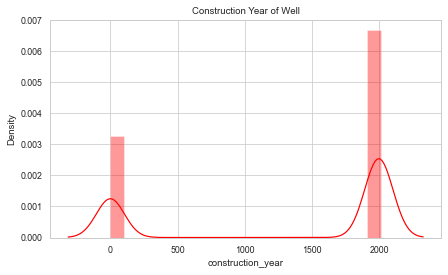

In [33]:
uni_analysis('construction_year',"Construction Year of Well")

In [34]:
print("Percentage of Missing Values in Construction year :",len(df[df['construction_year']> 0])/len(df))

Percentage of Missing Values in Construction year : 0.671870387413826


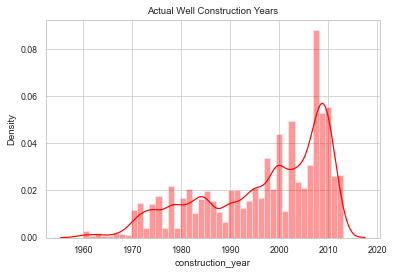

In [35]:
Const_year = df[df['construction_year']!=0]
sns.distplot(Const_year['construction_year'],color ='red')
plt.title("Actual Well Construction Years")
plt.show()

In [36]:
Const_year['construction_year'].describe()

count    38691.000000
mean      1996.814686
std         12.472045
min       1960.000000
25%       1987.000000
50%       2000.000000
75%       2008.000000
max       2013.000000
Name: construction_year, dtype: float64

Based on the provided data, the following conclusions can be drawn:
- The average construction year for the wells is 1996.
- The earliest well in the dataset was constructed in 1983.
- The most recent well in the dataset was constructed in 2013.
- A significant number of wells were constructed around the year 2010.

- As zero as a Construction Year is Not practical value unless they are from Jesus Era (haha) and will be treated as Missing Value.
- Number of Null Value in the Construction Year as Feature is more than 65%.The Imputation of missing values can change the feature distribution and comprise the realibilty of predictions.

#### Region

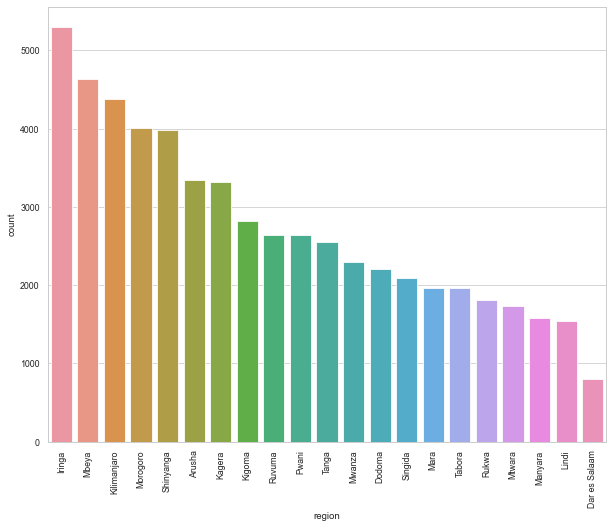

In [37]:
plt.figure(figsize = (10,8))
region_counts = df['region'].value_counts()
region_sort = region_counts.index

sns.countplot(data=df, x='region', order=region_sort)

plt.xticks(rotation=90)
plt.show()

#### Region Code

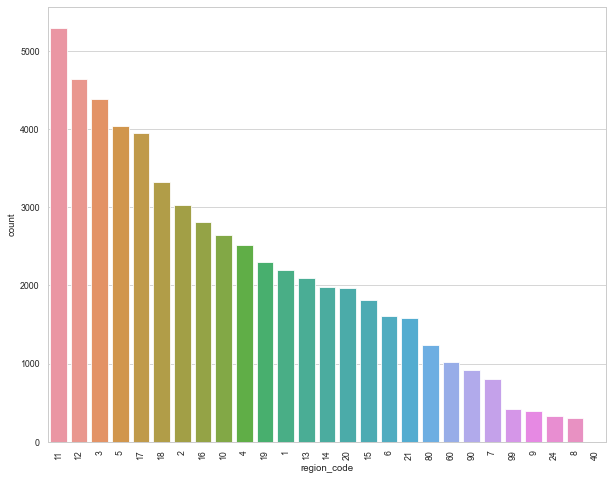

In [38]:
plt.figure(figsize = (10,8))

region_counts = df['region_code'].value_counts()
region_sort = region_counts.index

sns.countplot(data=df, x='region_code', order=region_sort)

plt.xticks(rotation=90)
plt.show()

- Number of Regions are 21 but Number of Region Code are 27 which may be due some larger areas might have been divided into different region Codes

### Impact of Independent Features on the Functionality of Wells

#### Effect of Years on Functionality of Wells

In [39]:
df['construction_year'].value_counts(normalize = True)[:6]

0       0.328130
2010    0.045931
2008    0.045375
2009    0.043986
2000    0.036310
2007    0.027558
Name: construction_year, dtype: float64

In [40]:
#Analysis on Construction Year Without Missing Values
Const_year = df[df['construction_year']!=0]

const =Const_year.groupby(['construction_year', 'status_group']).size().reset_index(name='count')

In [41]:
# Making a Pivot Table for each Category of Status Group
pivot_table = const.pivot_table(index='construction_year', columns='status_group',
                               values='count', aggfunc='sum', fill_value=0)
pivot_table.head()

status_group,functional,functional needs repair,non functional
construction_year,,,
1960,24,6,72
1961,2,3,16
1962,7,1,22
1963,31,6,48
1964,7,1,32


In [42]:
pivot_table['Total'] = pivot_table[['functional', 'functional needs repair', 'non functional']].sum(axis=1)

In [43]:
pivot_table =pivot_table.reset_index()
pivot_table.head()

status_group,construction_year,functional,functional needs repair,non functional,Total
0,1960,24,6,72,102
1,1961,2,3,16,21
2,1962,7,1,22,30
3,1963,31,6,48,85
4,1964,7,1,32,40


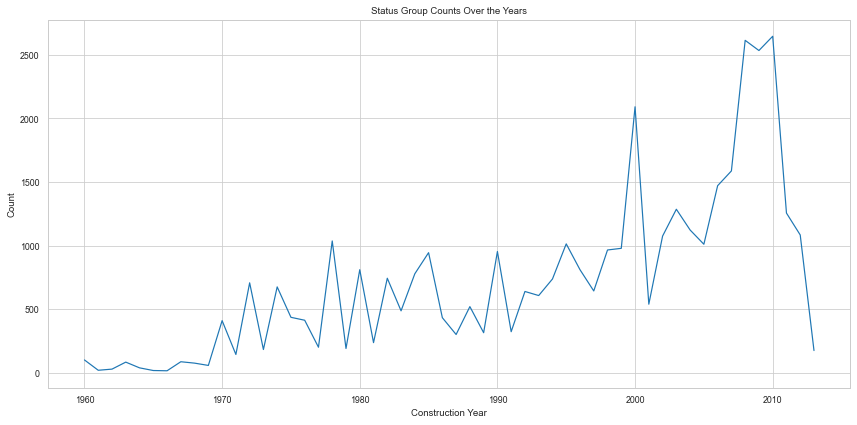

In [44]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='construction_year', y='Total', data=pivot_table)

plt.xlabel('Construction Year')
plt.ylabel('Count')

plt.title('Status Group Counts Over the Years')

plt.tight_layout()
plt.show()

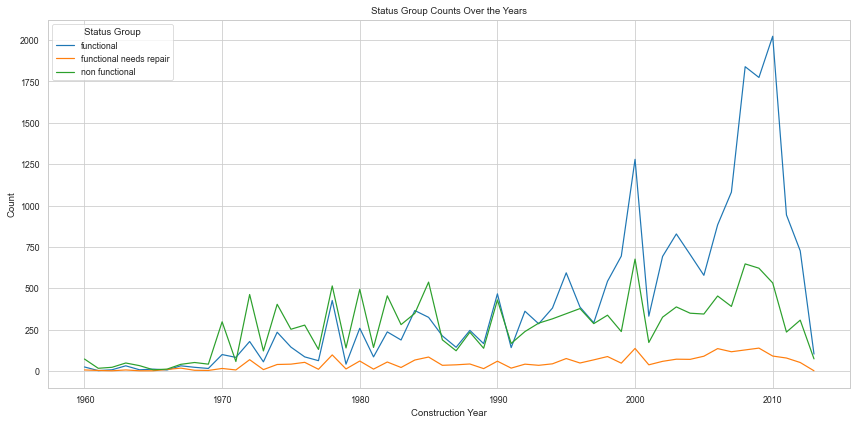

In [45]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='construction_year', y='count', hue='status_group', data=const)

plt.xlabel('Construction Year')
plt.ylabel('Count')

plt.title('Status Group Counts Over the Years')
plt.legend(title='Status Group')
plt.tight_layout()
plt.show()

- In practice, one might expect the count of Functional Wells to decrease over the years. However, it's interesting to note that the maximum number of functional wells occurs in 2010, possibly due to a significant number of wells being constructed in that year.


- The count of Non-Functional Wells has shown volatility over the years, which suggests there may have been ongoing repairs and maintenance. This volatility likely stems from wells transitioning from non-functional to functional due to repairs, indicating a changing well category. This phenomenon has also contributed to the fluctuation in counts over time.This is just a conclusion on available non missing data and cannot be full drawn.


- Second Reason might have been the Missing Values given as Zero as the Total Count of Wells each Year is Varying.We cannot draw Any Concrete Conclusion from the Construction Year Feature impact on Dependent Variable

#### Anamoly Detection

In [46]:
df['date_recorded'] = pd.to_datetime(df['date_recorded'])

# For the Analysis
df['Reorded_Year'] = df['date_recorded'].dt.year

df['Recorded_Month']= df['date_recorded'].dt.month_name() #For month name

In [47]:
anomaly = df[df['Reorded_Year'] < df['construction_year']]
df = df.drop(anomaly.index)

- As the Year of Recoreded Date of Data point Cannot be less than the Construction Year

### Geospatial Comparision with Functinality of Well

**Latitude:**

- (+) values of latitude are in the northern hemisphere, indicating a location north of the equator.
- (-) values of latitude are in the southern hemisphere, indicating a location south of the equator.
- A latitude of 0 degrees is at the equator.

**Longitude:**

- (+) of longitude are in the eastern hemisphere, indicating a location east of the prime meridian.
- (-) values of longitude are in the western hemisphere, indicating a location west of the prime meridian.
- A longitude of 0 degrees is at the prime meridian.

In [48]:
df['status_group'].value_counts()

functional                 31384
non functional             22263
functional needs repair     3931
Name: status_group, dtype: int64

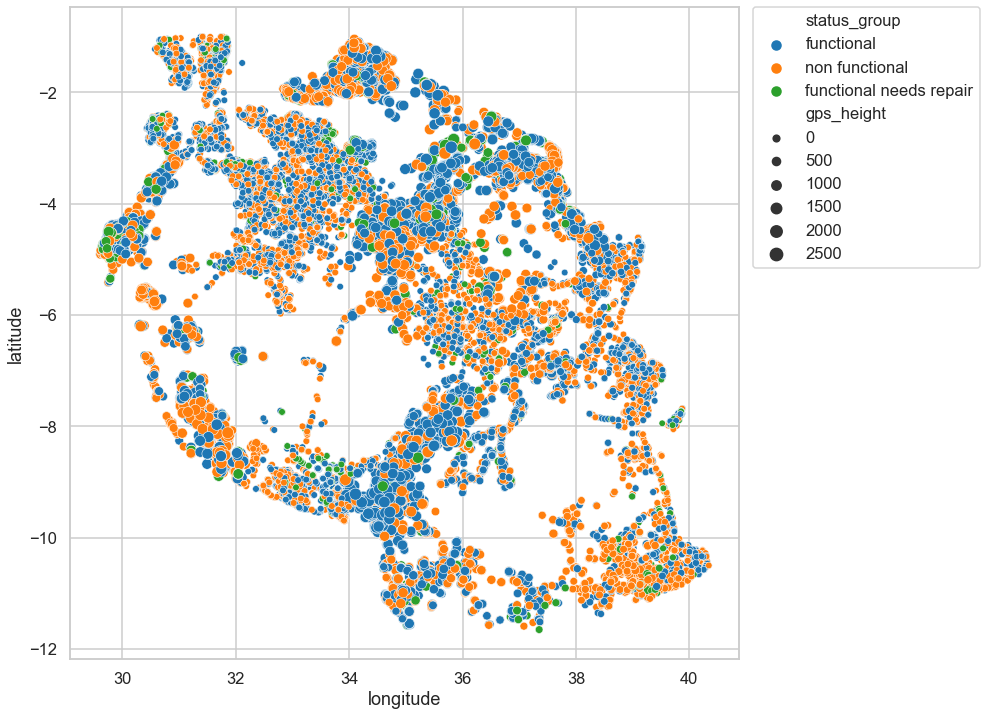

In [49]:
sns.set_context('talk')
plt.figure(figsize = (12,12))

sns.scatterplot(x ='longitude',y ='latitude',size= 'gps_height',hue = 'status_group',
                data = df)

plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

plt.show()

#### Functional Wells in Tanzania

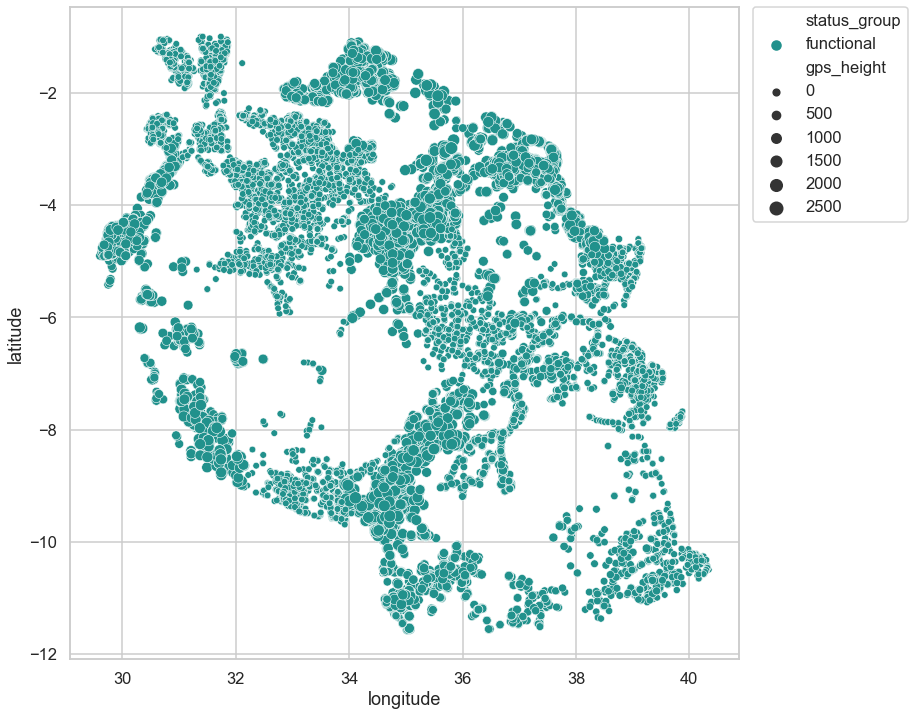

In [50]:
sns.set_context('talk')
plt.figure(figsize = (12,12))

sns.scatterplot(x ='longitude',y ='latitude',size= 'gps_height',hue = 'status_group',
                data = df[df['status_group']=='functional'],palette = "viridis" )

plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

plt.show()

- SouthEast and SouthWest Areas : Fuctional Well Altitude More than 1500.
- NorthWest Areas : Fuctional Wells Altutide with less than 1000. 

#### Non Functional Wells in Tanzania 

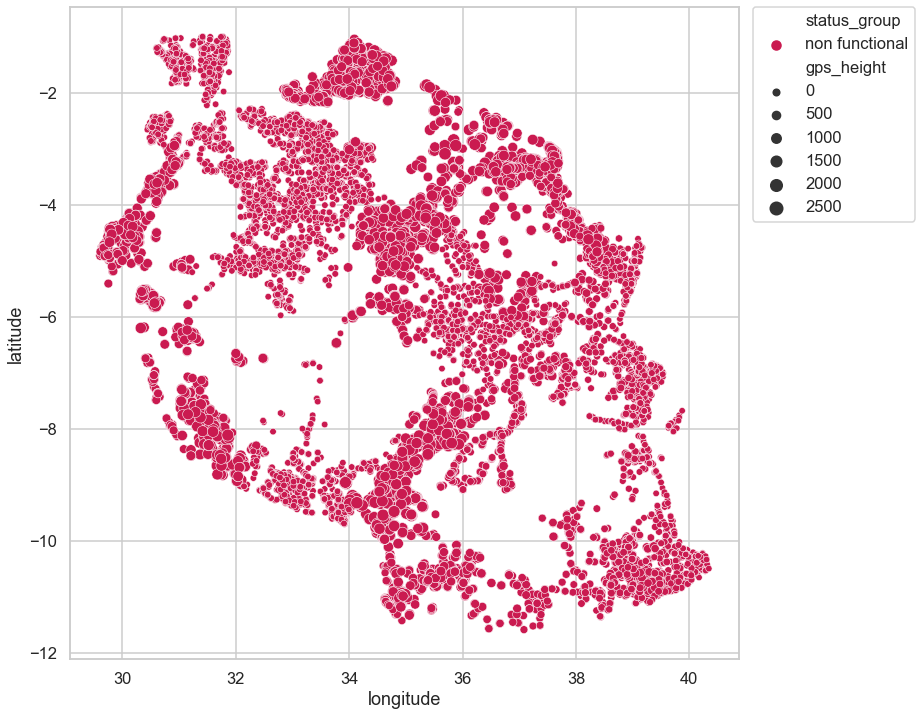

In [51]:
plt.figure(figsize = (12,12))
sns.scatterplot(y = 'latitude',x= 'longitude',size= 'gps_height',hue = 'status_group',
                data = df[df['status_group']=='non functional'],palette = 'rocket_r' )
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.show()

<Axes: xlabel='population'>

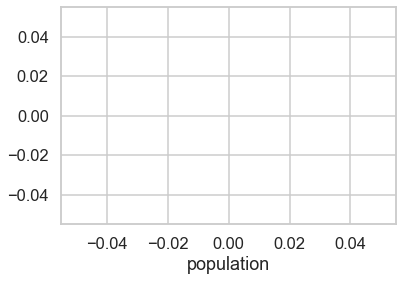

In [52]:
sns.scatterplot(x = 'population',data = df)

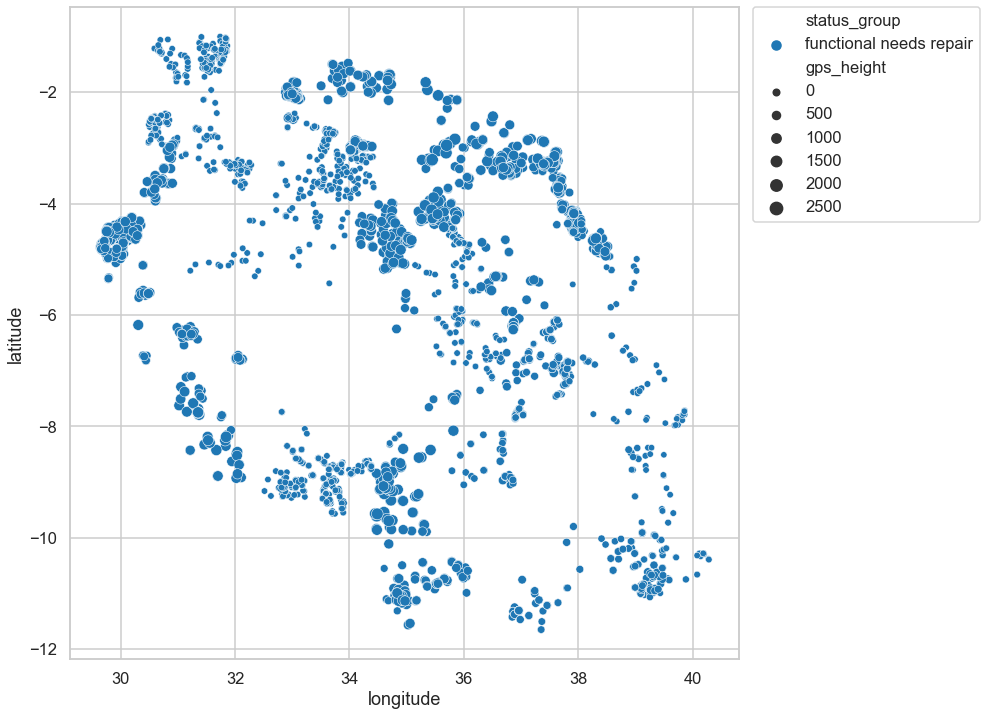

In [53]:
plt.figure(figsize = (12,12))

sns.scatterplot(x = 'longitude',y = 'latitude',size= 'gps_height',hue = 'status_group',
                data = df[df['status_group']=='functional needs repair' ],palette = 'tab10')
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.show()

**Map Comparison Insights:**

- A significant number of wells 1500 well altitude are strategically located around freshwater bodies like Lake Nyasa in the southwestern region and Lake Victoria in the northeastern region of Tanzania, aligning with the map's geography.


- Notably, there is a considerable absence of well constructions along rivers, possibly attributed to rivers' natural role as drainage channels. When a river's elevation is lower than the surrounding land, it prompts groundwater to flow toward the river, leading to lower groundwater levels nearby.


- However, there's an interesting exception with a dense cluster of wells around the Rufiji. But the river's decreased flows since the early 1990s and continuos dry spells may be the reason behind extensive well construction found in this area are non functional . This phenomenon could be linked to inadequate water management and unregulated rice irrigation schemes, factors that have contributed to the river's diminished water supply. More details about the Great Ruaha River can be found [here](https://en.wikipedia.org/wiki/Great_Ruaha_River)

#### Fuction for Visualization

In [54]:
def plot_stackedbar(df, title, figsize):
    colors = ['#0362FF','#03FF98','#FF030F']
    labels = list(df.columns)

    fig, ax = plt.subplots(1, figsize=figsize)
    left = len(df) * [0]
    
    for idx, name in enumerate(labels):
        plt.barh(df.index, 
                 df[name], 
                 left=left, 
                 color=colors[idx], 
                 height=0.4)
        left = left + df[name]
        
    # title and subtitle
    plt.title(title, loc='left', fontsize=20, pad=40)
    
    # legend
    plt.legend(labels, 
               bbox_to_anchor=([1, 1, 0.38, 0]), 
               ncol=3, 
               frameon=True, 
               fontsize=14)

    # adjust limits and draw grid lines
    plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
    ax.xaxis.grid(color='gray', linestyle='dashed')
    
    # reset font size for yticks
    ax.tick_params(axis='both', which='major', labelsize=15)
    
plt.show()

#### Region

In [55]:
def crosstab(col):
    data = pd.crosstab(df[col], df['status_group'])
    data = data.sort_values(by='functional', ascending=False)
    return data

In [56]:
region = crosstab('region')
region

status_group,functional,functional needs repair,non functional
region,,,
Iringa,4140,123,1030
Kilimanjaro,2640,322,1417
Mbeya,2319,504,1816
Arusha,2294,175,881
Shinyanga,2289,295,1393
Morogoro,2119,300,1587
Kagera,1726,304,1285
Pwani,1555,36,1041
Ruvuma,1480,164,996


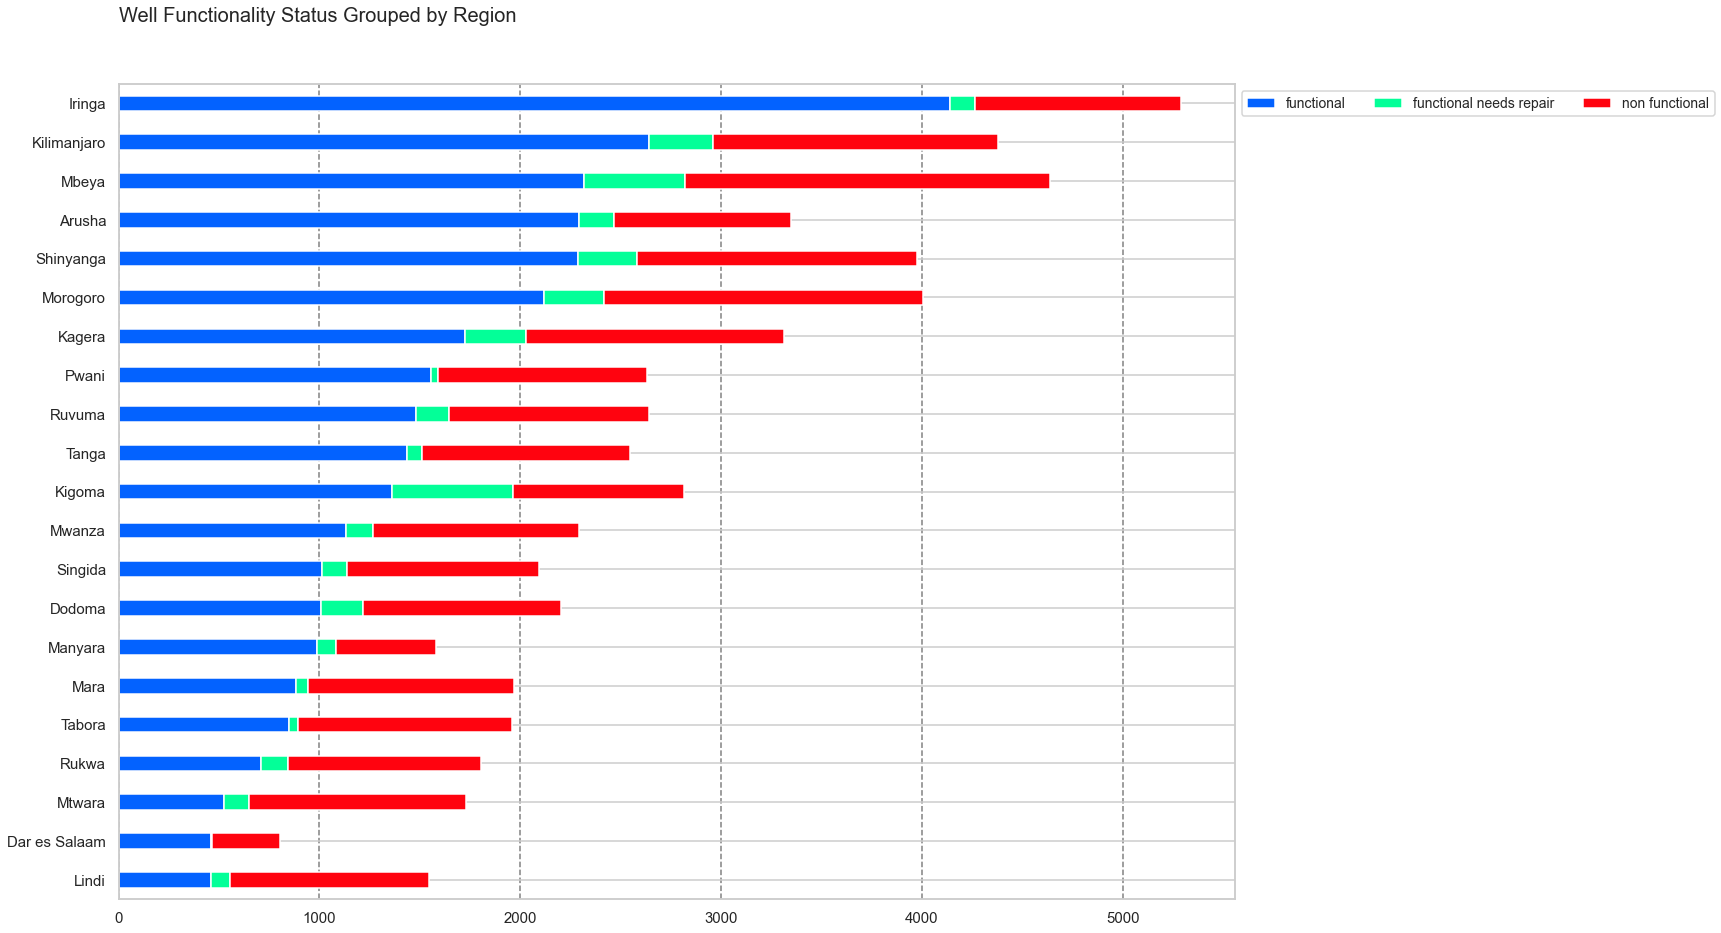

In [57]:
region_wise = pd.crosstab(df['region'], df['status_group']).sort_values(by='functional')
title = 'Well Functionality Status Grouped by Region\n'
plot_stackedbar(region_wise, title, (20,15))

- Even though Dodoma serves as the capital of Tanzania and ranks as the 8th most populous city in the nation, it notably lacks a substantial number of wells in comparison to other urban areas. 


- Interestingly, despite Dar es Salaam holding the status of being the largest and most densely populated city, it surprisingly exhibits the lowest count of wells across the country. Moreover, the number of functional wells in Dar es Salaam is also remarkably deficient, which is worrying considering the city's population size.


- As Dar es Salaam is on coastal regions its ground water may have been infiltrated by Sea's Salt water or groundwater levels in these aquifers can be affected by changes in the tides and the water table might fluctuate more closely in sync with the ocean may be the reason of less well in Dar es Salaam


- Despite Lindi having a greater number of wells compared to Dar es Salaam, it has the lowest count of operational wells in the country.


- Iringa contains the highest number of wells, and it also leads in terms of functional wells.


- The status of wells appears to be closely tied to specific regions, as indicated by the chart. Regions with higher population densities and local government presence around wells tend to has its benefits in terms of regular maintenance and repair.

#### Water Quality

In [58]:
water_quality = crosstab('water_quality')
water_quality

status_group,functional,functional needs repair,non functional
water_quality,,,
soft,27978,3605,17839
salty,2193,199,2380
milky,437,14,352
unknown,250,34,1377
coloured,246,51,182
fluoride,150,13,36
salty abandoned,126,15,86
fluoride abandoned,4,0,11


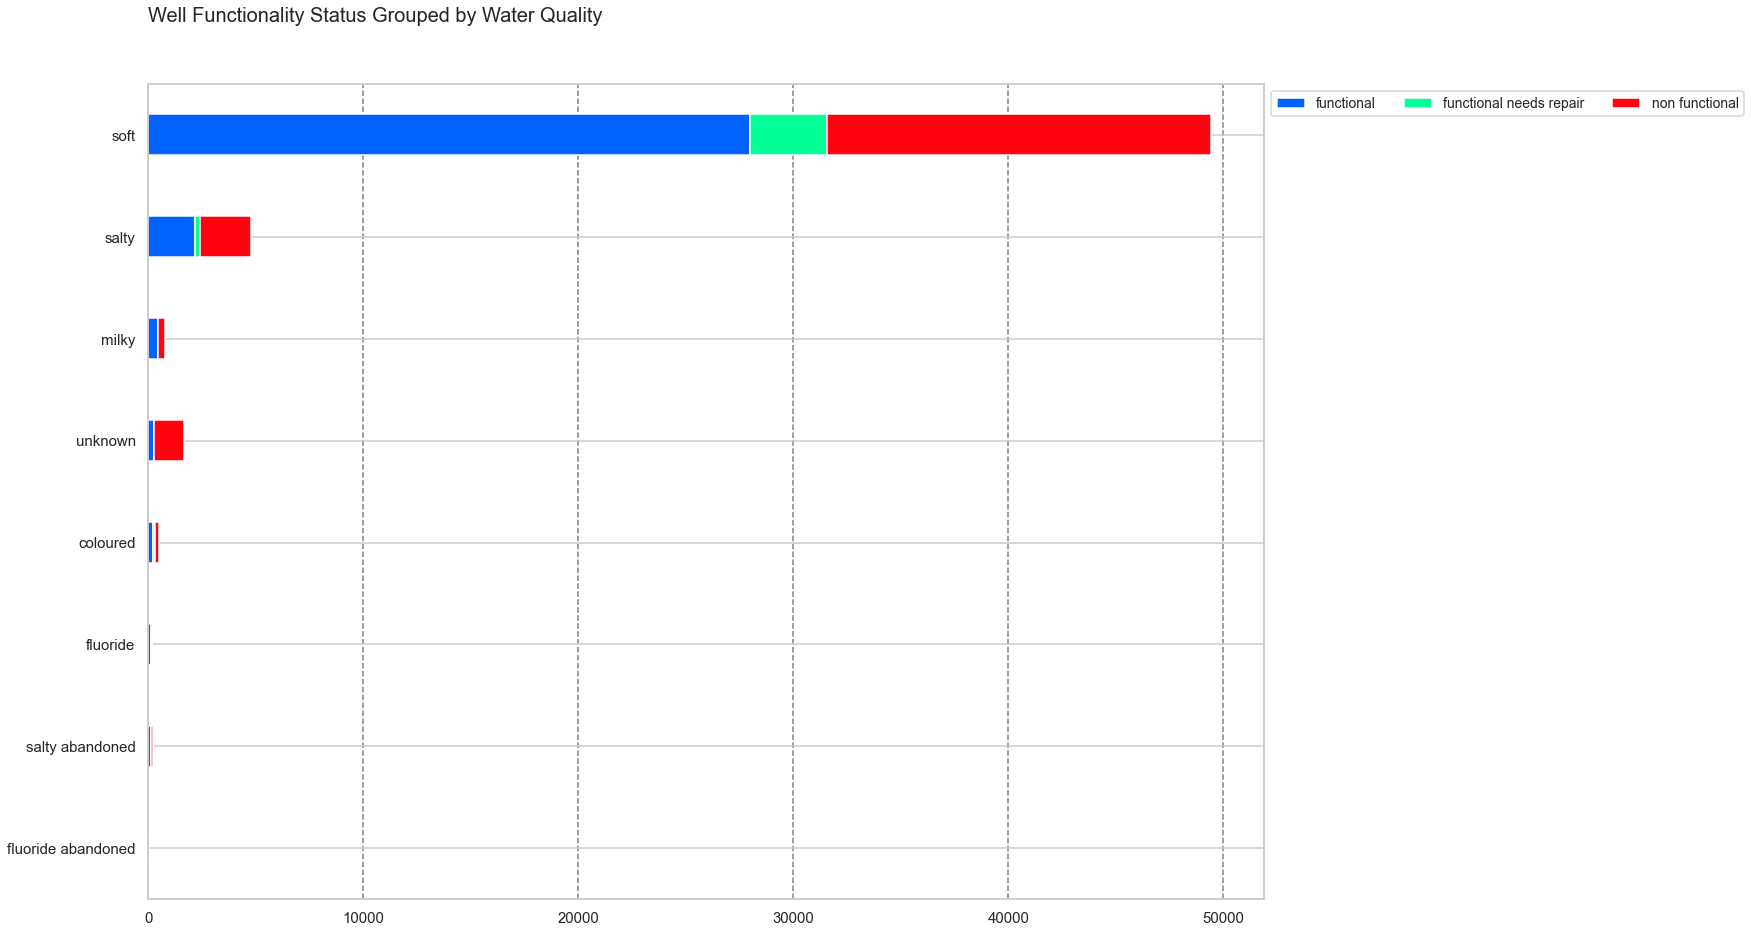

In [59]:
water_qual = pd.crosstab(df['water_quality'], df['status_group']).sort_values(by='functional')
title = 'Well Functionality Status Grouped by Water Quality\n'
plot_stackedbar(water_qual, title, (20,15))

- It's well understood that a higher quantity of wells is more likely to have water of "soft" quality compared to any other water quality category.

#### Water Quantity

In [60]:
water_quantity = crosstab('quantity')
water_quantity

status_group,functional,functional needs repair,non functional
quantity,,,
enough,21116,2161,8977
insufficient,7605,1323,5636
seasonal,2308,400,1292
unknown,201,13,559
dry,154,34,5799


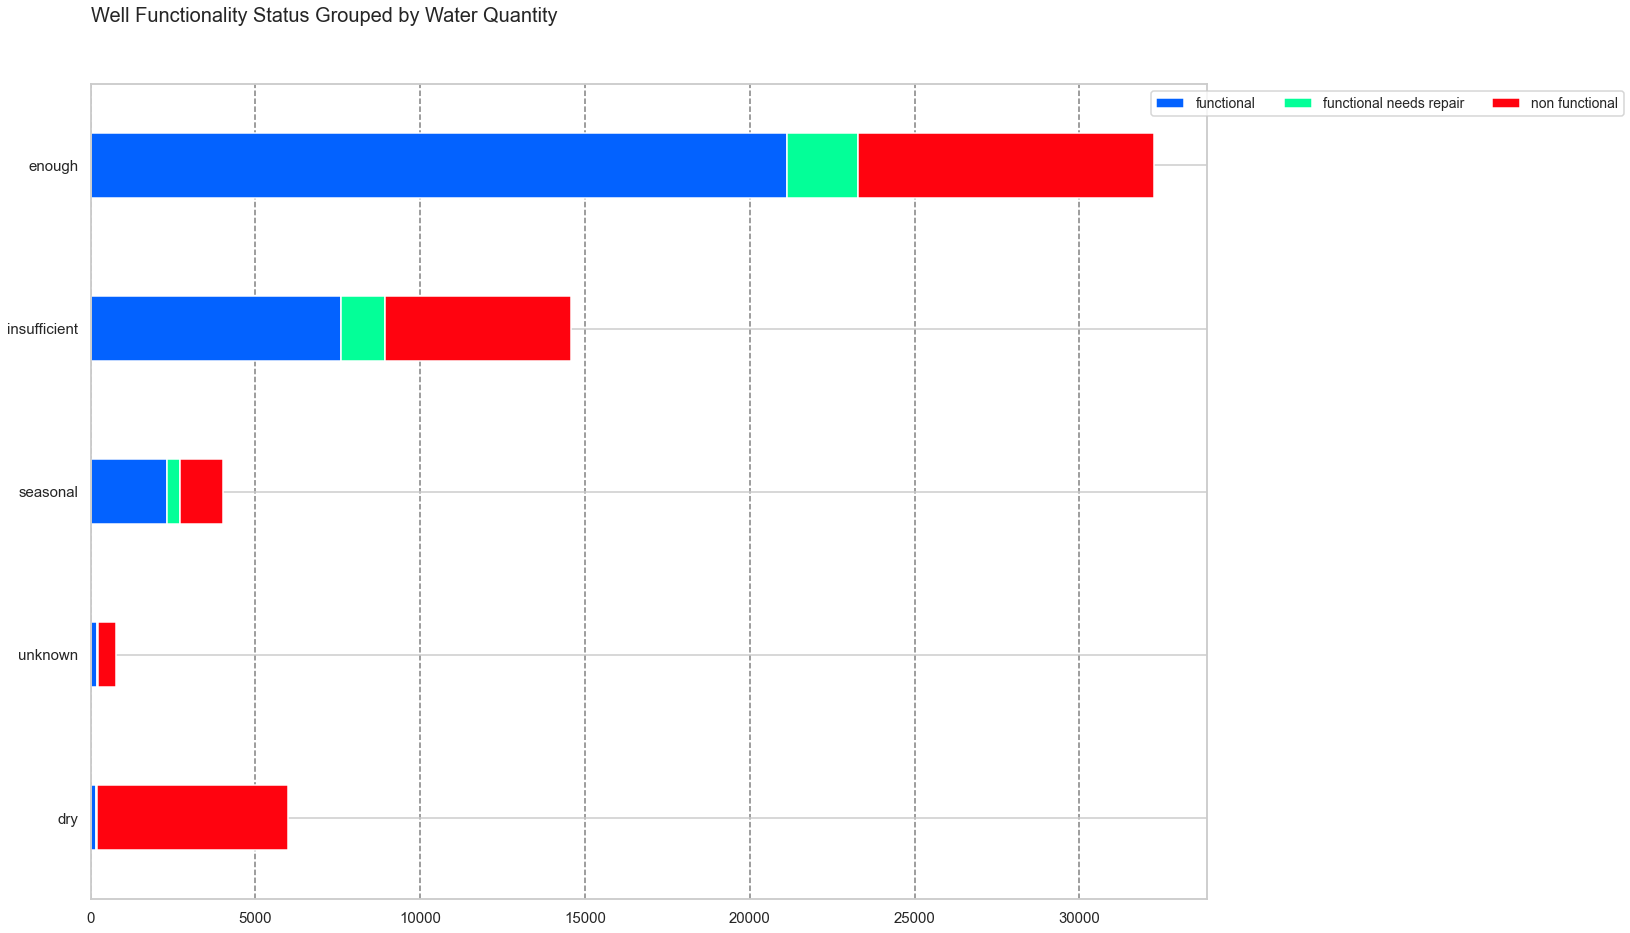

In [61]:
water_quan = pd.crosstab(df['quantity'], df['status_group']).sort_values(by='functional')
title = 'Well Functionality Status Grouped by Water Quantity\n'
plot_stackedbar(water_quan, title, (20,15))

- Analyzing the data reveals a strategic placement of wells around abundant groundwater sources. This is evident from the amount of wells with ample water availability.

- However, despite this strategic positioning, water scarcity affects certain regions, indicating that the amount of well with insufficiency of water quantity ranks as the second most.

- Seasonal wells could originate from regions with lower water levels, serving as reservoirs for rainwater storage.

- Ultimately, it's clear that non functional wells are predominantly those that have run dry.

#### Source

In [62]:
source = crosstab('source')
source

status_group,functional,functional needs repair,non functional
source,,,
spring,10579,1275,5148
shallow well,7682,604,7209
river,5465,1221,2926
machine dbh,5281,478,5067
rainwater harvesting,1335,295,587
hand dtw,496,17,359
dam,253,24,372
lake,135,12,492
other,126,1,75


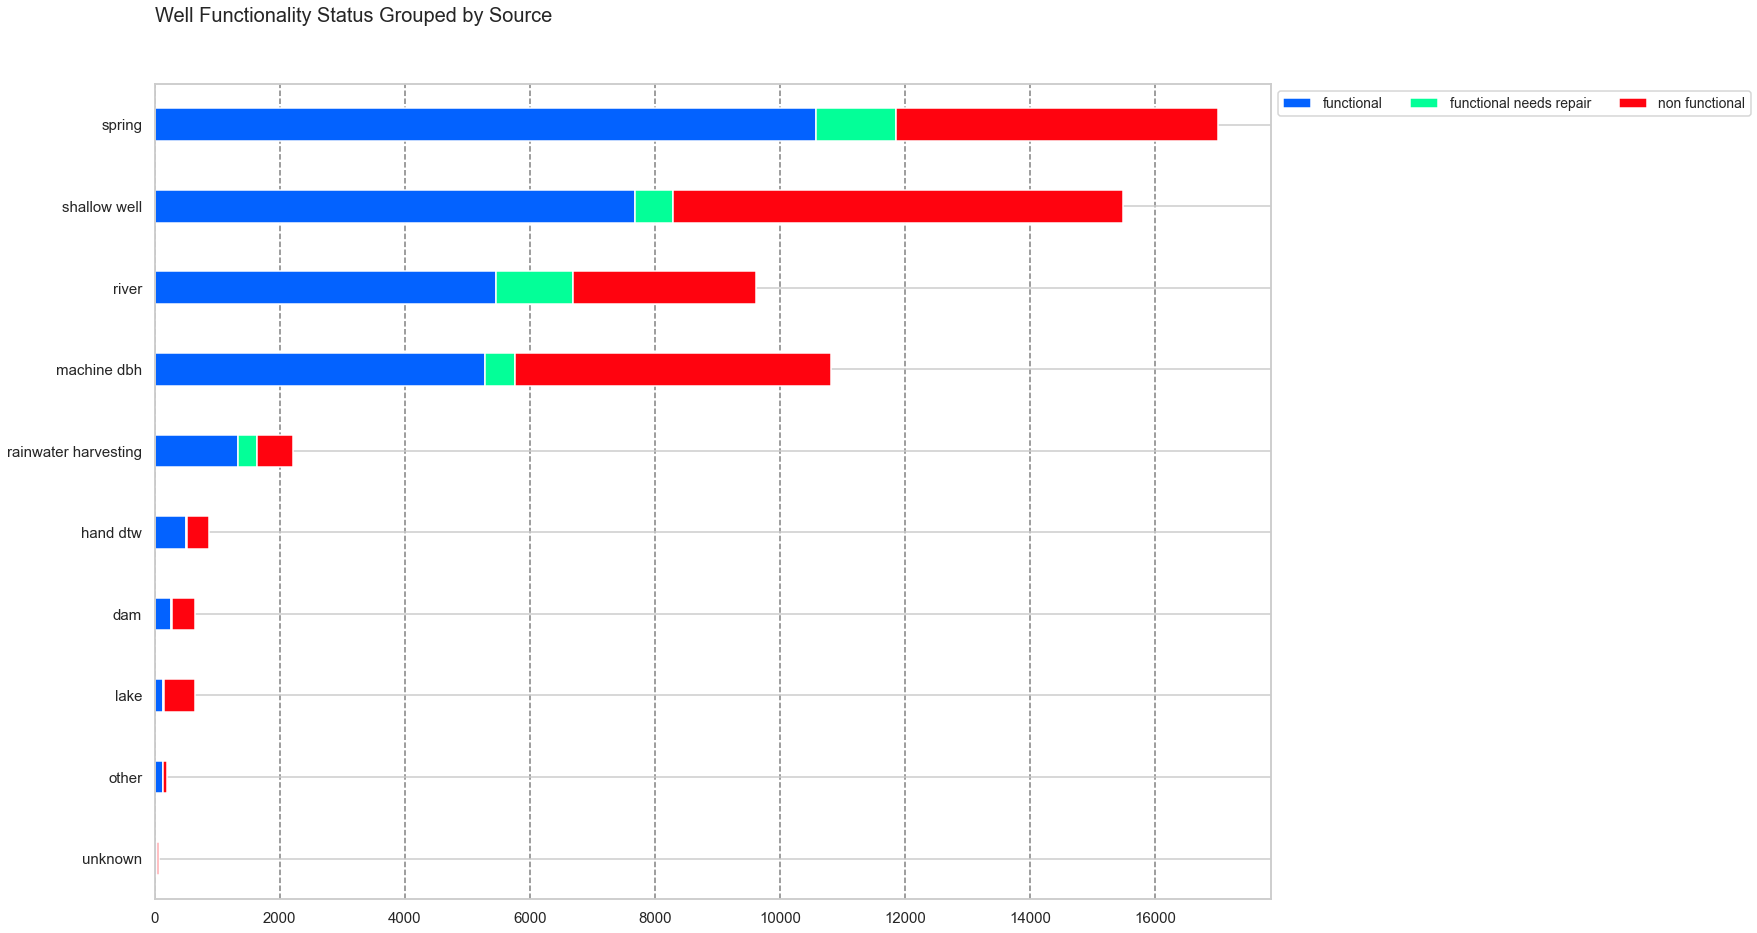

In [63]:
source = pd.crosstab(df['source'], df['status_group']).sort_values(by='functional')
title = 'Well Functionality Status Grouped by Source\n'
plot_stackedbar(source, title, (20,15))

-  Highest total number of wells are dependent on **Spring** as a Source , with a significant portion being non functional, potentially indicating challenges with maintenance or water availability (**Drastically Reducing Ground Water**).


-  A substantial number of total wells have Shallow wells as source , with a relatively balanced distribution between functional and non functional(**44.8% which is higher than average 38%**). Maintenance and groundwater levels might impact their functionality.


- Rivers Source exhibit a relatively higher proportion of functional wells (**57%**) compared to non functional ones (**30%**), suggesting they are generally more reliable water sources.This can be because a signficantly high number of wells are constructed in the vicinity of Rufiji River when compared with practical map of Tanzania.


- **Rainwater Harvesting** has more functional wells which are around **60%** indicating as good technique to fight against scarcity challenges.


#### WaterPoint Type

In [64]:
waterpoint_type = crosstab('waterpoint_type')
waterpoint_type

status_group,functional,functional needs repair,non functional
waterpoint_type,,,
communal standpipe,17646,2241,8486
hand pump,10040,667,5469
communal standpipe multiple,2210,648,3100
other,836,288,5042
improved spring,562,85,135
cattle trough,84,2,30
dam,6,0,1


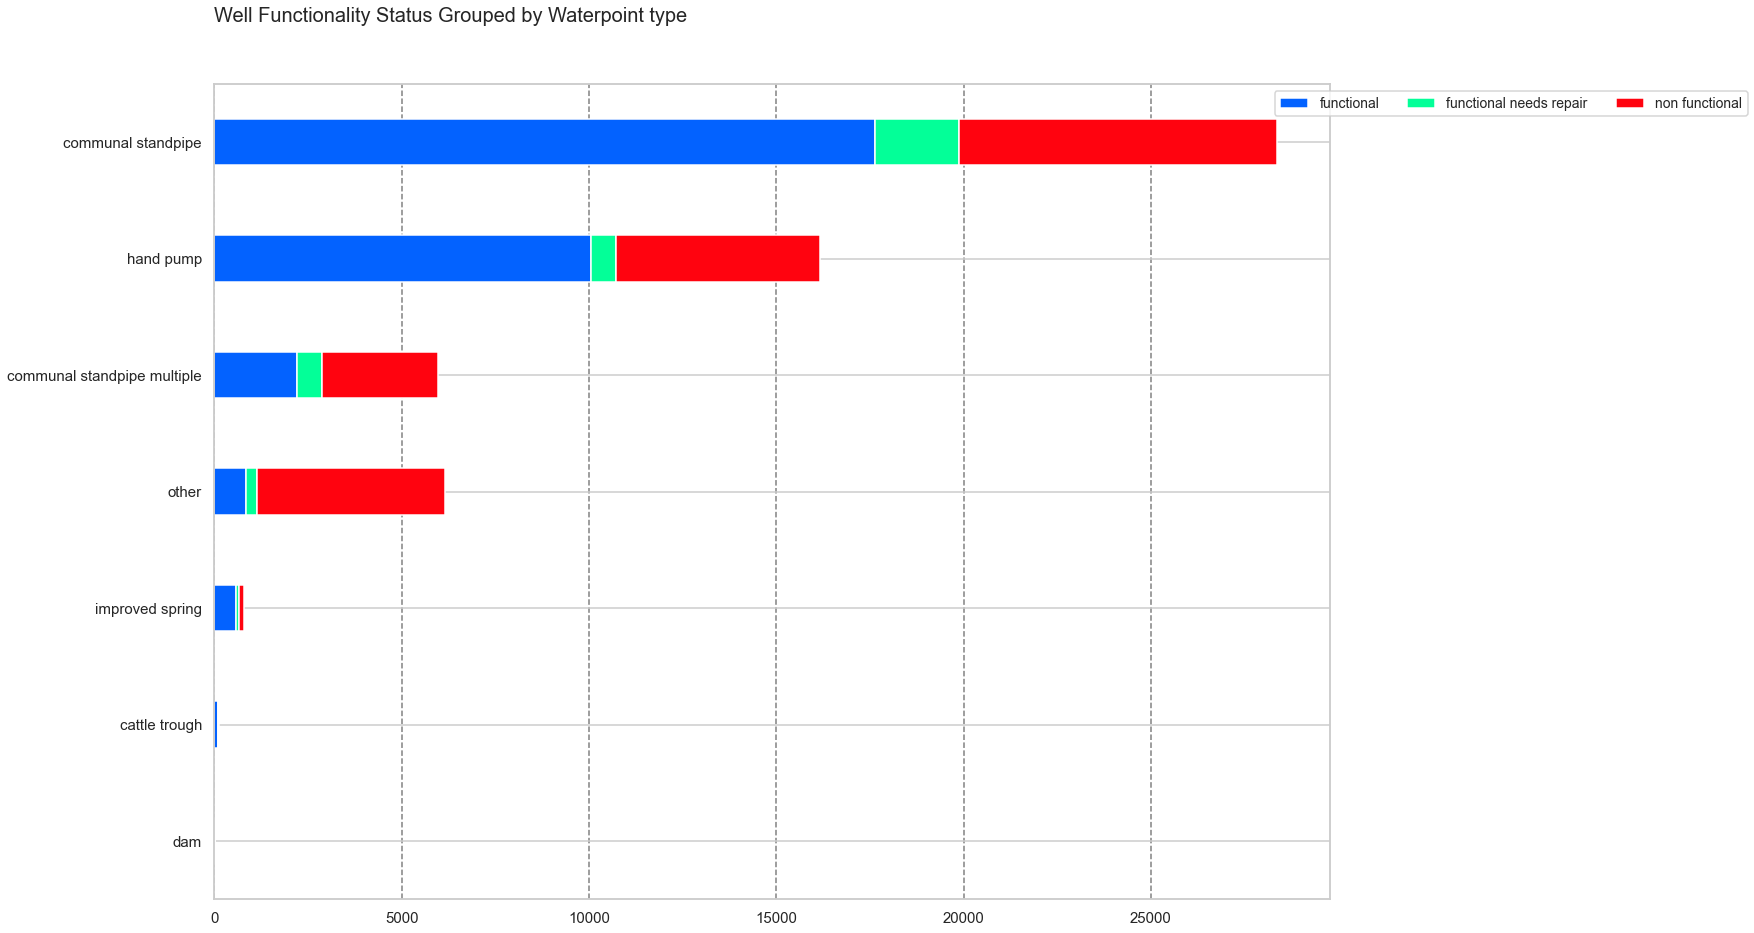

In [65]:
waterpoint_type = pd.crosstab(df['waterpoint_type'], df['status_group']).sort_values(by='functional')
title = 'Well Functionality Status Grouped by Waterpoint type\n'
plot_stackedbar(waterpoint_type, title, (20,15))

#### Extraction Type

In [66]:
extraction_type = crosstab('extraction_type_class')
extraction_type

status_group,functional,functional needs repair,non functional
extraction_type_class,,,
gravity,16019,2689,7984
handpump,9626,634,4915
submersible,3296,253,2497
motorpump,1115,138,1686
other,986,193,4980
rope pump,292,17,141
wind-powered,50,7,60


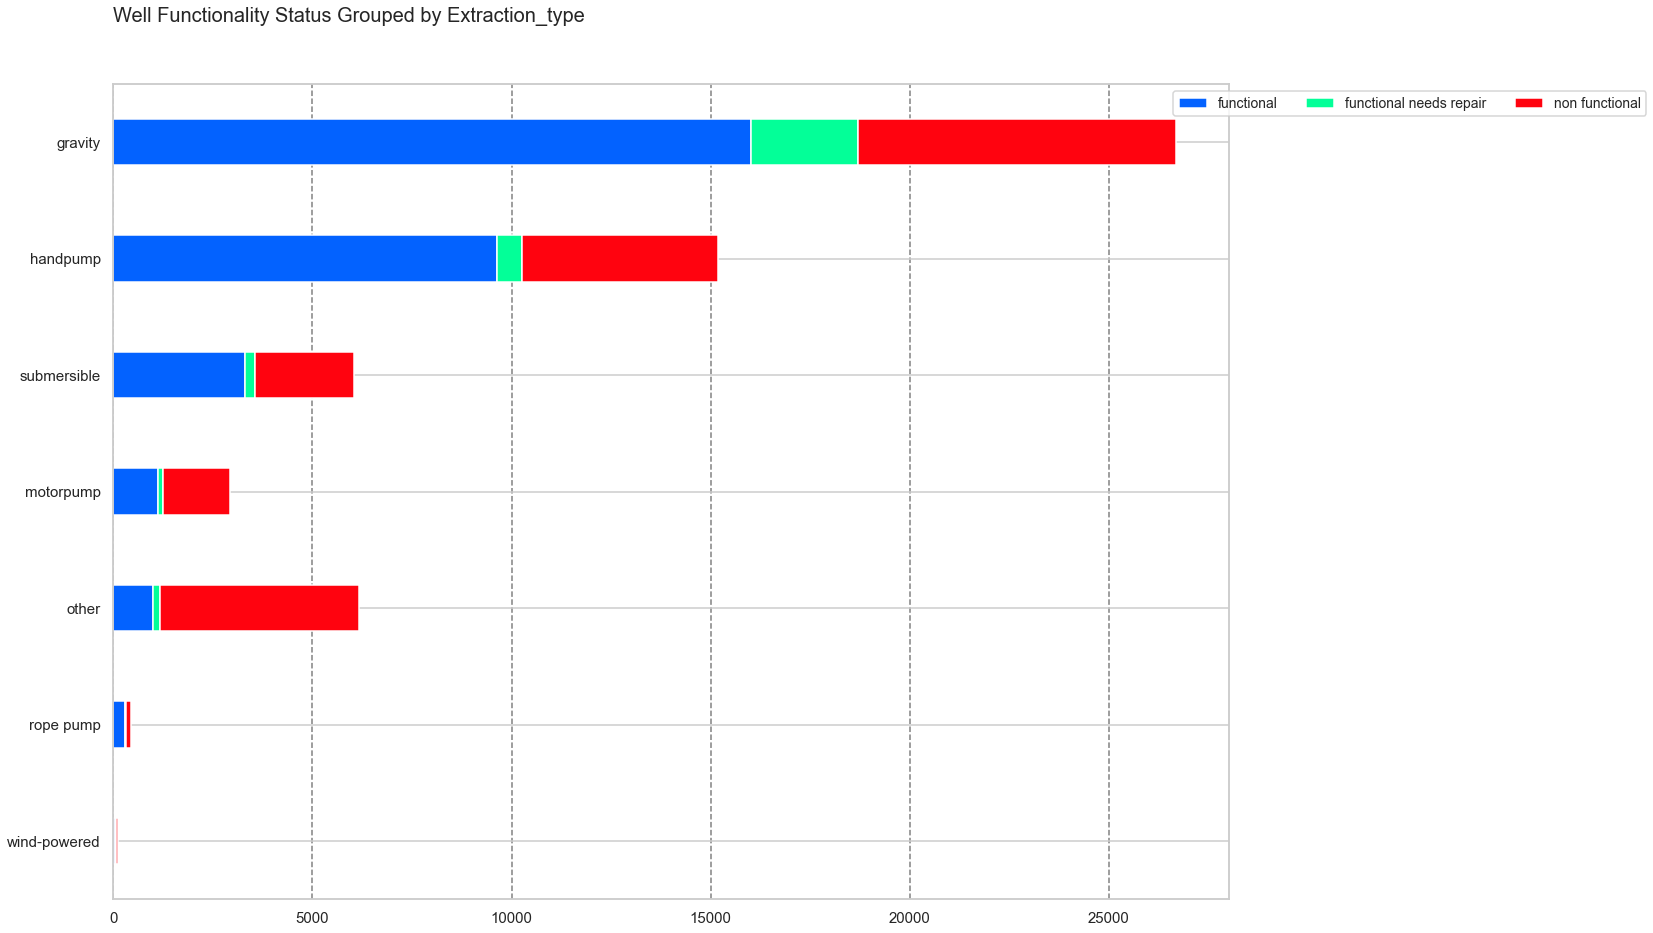

In [67]:
extraction_type = pd.crosstab(df['extraction_type_class'], df['status_group']).sort_values(by='functional')
title = 'Well Functionality Status Grouped by Extraction_type\n'
plot_stackedbar(extraction_type, title, (20,15))

- Despite being very less in Number the **Rose Pump**, Functional Well proportion is higher than average which is 65%.May be geological factor or may be it requires less maintainence

- Other has the highest proportion of Non Functional Well which is **87%**. 

#### Basin

In [68]:
basin = crosstab('basin')
basin

status_group,functional,functional needs repair,non functional
basin,,,
Pangani,5372,477,3089
Rufiji,5067,437,2469
Internal,4482,557,2746
Lake Victoria,4289,607,3637
Lake Nyasa,3324,250,1511
Wami / Ruvu,3135,269,2582
Lake Tanganyika,3046,738,2548
Ruvuma / Southern Coast,1669,326,2497
Lake Rukwa,1000,270,1184


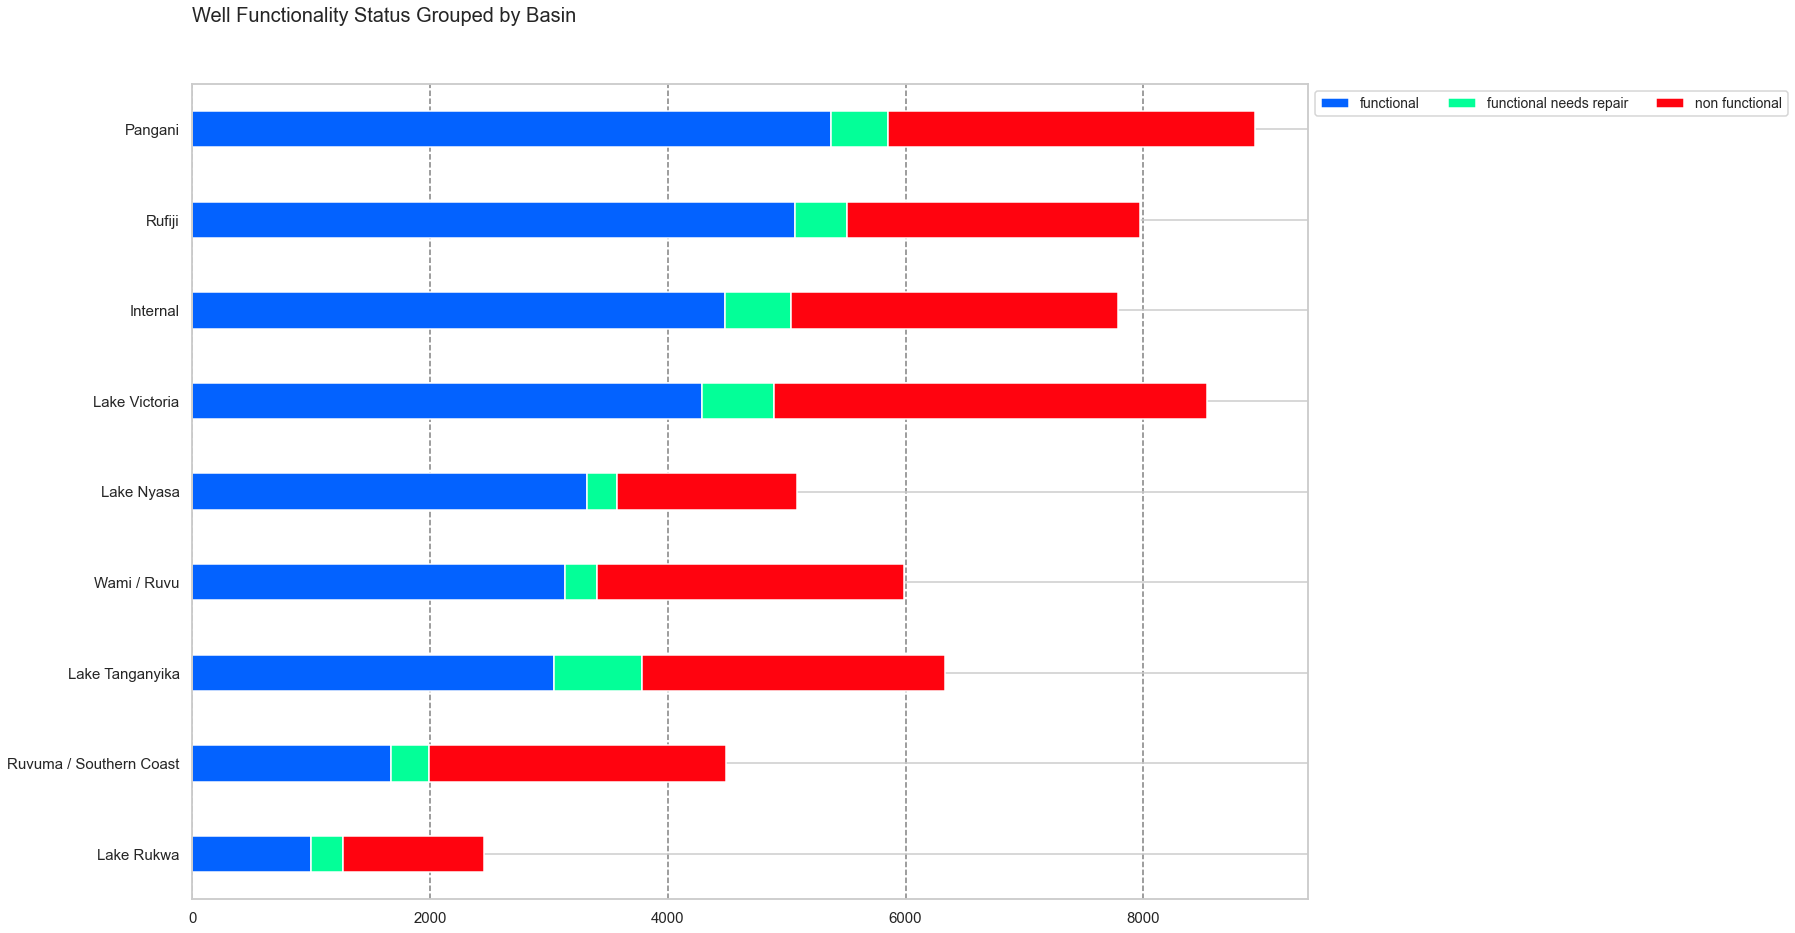

In [69]:
basin = pd.crosstab(df['basin'], df['status_group']).sort_values(by='functional')
title = 'Well Functionality Status Grouped by Basin\n'
plot_stackedbar(basin, title, (20,15))

 Among all regions, Pangani has the highest total number of wells, with a noteworthy **34%** of these wells classified as non functional.


Lake Nyasa stands out for maintaining a remarkably low proportion of non functional wells, approximately **30%**, even though it has fewer total wells. This trend suggests ample groundwater availability and effective well maintenance practices.

Interestingly, in contrast to Pangani's situation despite sharing a coastline, this region presents the highest proportion of non functional wells.

In [70]:
scheme_management = crosstab('scheme_management')
scheme_management

status_group,functional,functional needs repair,non functional
scheme_management,,,
VWC,18642,2311,15182
WUG,2507,367,1375
Water Board,2053,110,584
WUA,1994,239,649
Water authority,1616,448,1087
Parastatal,940,171,496
Private operator,728,23,311
Company,534,37,490
Other,457,22,285


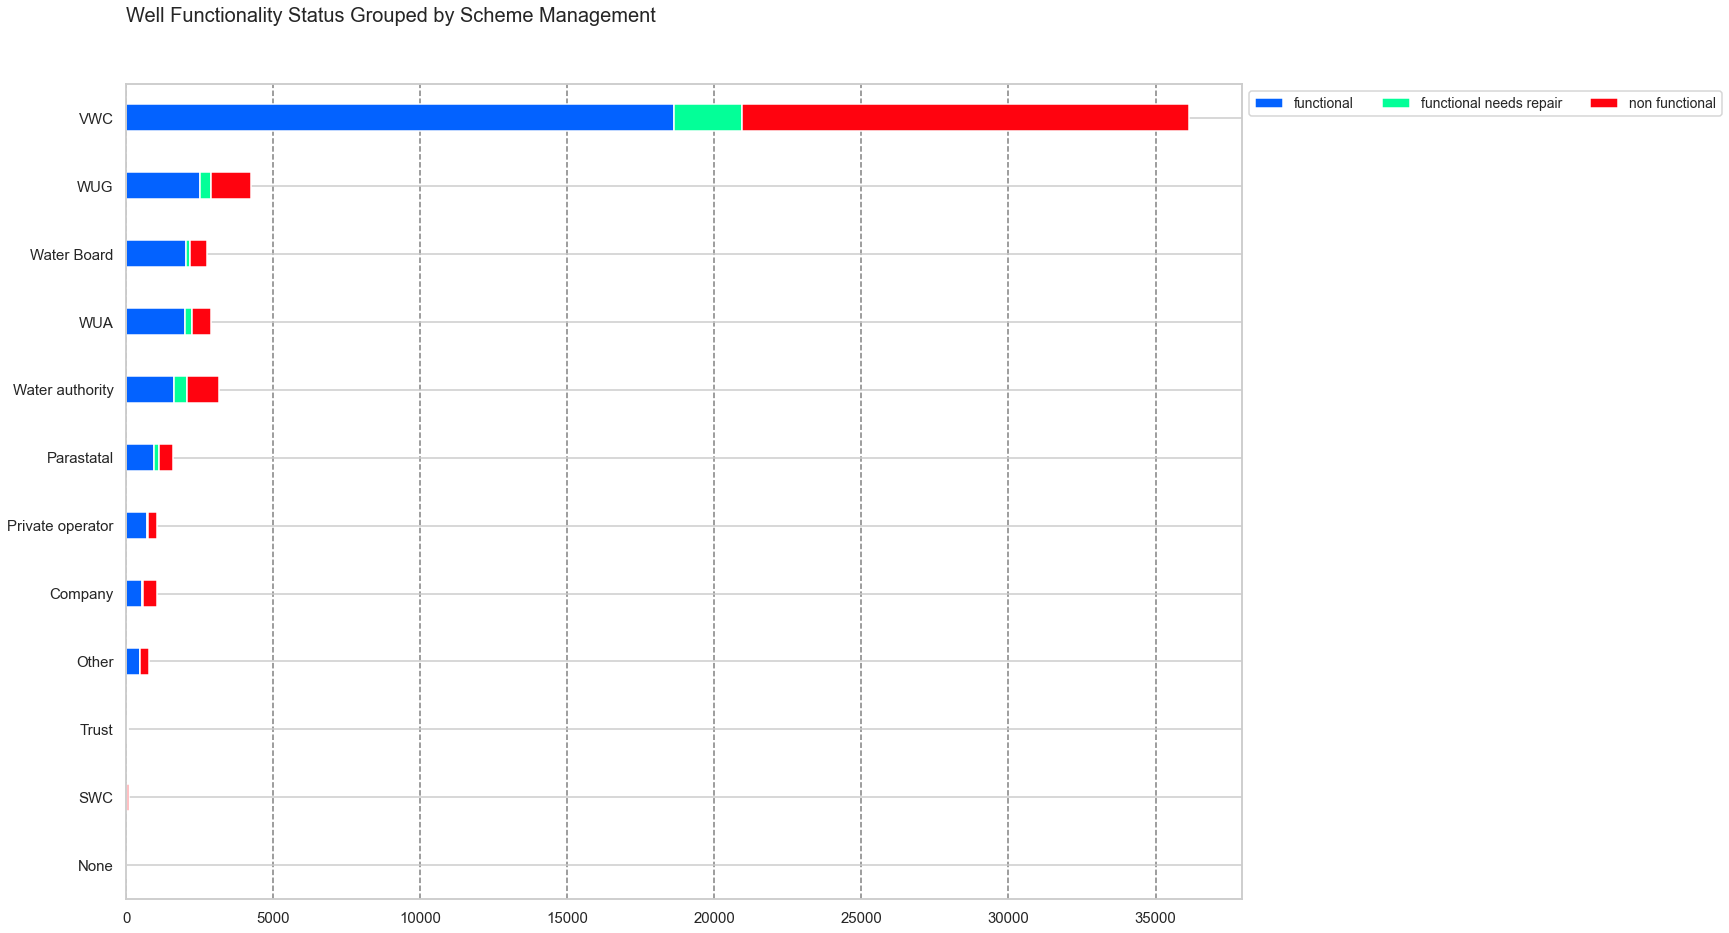

In [71]:
scheme_management = pd.crosstab(df['scheme_management'], df['status_group']).sort_values(by='functional')
title = 'Well Functionality Status Grouped by Scheme Management\n'
plot_stackedbar(scheme_management, title, (20,15))

- Almost **80%** of the Total wells are managed and operated by VWC with Around **42%** are Non Functional which can be due to Lack of Negligence from VWC.
- Scheme Managment as Feature is Highly Imbalanced and which comprises its reliability for Model Predictions

#### Recorded Date

**As Observed Earlier that Rain Water Harvesting has the promising Number of Functional Pump.
We can use Recorded Dates as a Source to Extract Monthly and Yearly impact on Functionality of Well.To detect the relation of how specific periods affects the functionality of well.**

In [72]:
Recorded_Month = crosstab('Recorded_Month')
Recorded_Month

status_group,functional,functional needs repair,non functional
Recorded_Month,,,
March,11054,900,5974
February,6639,803,4565
July,3295,524,2844
October,2622,260,2252
January,2454,659,2849
April,2050,438,1482
August,1579,241,1242
November,651,58,547
December,355,19,214


In [73]:
Recorded_Month = pd.crosstab(df['Recorded_Month'], df['quantity']).sort_values(by='dry',ascending =False)
Recorded_Month

quantity,dry,enough,insufficient,seasonal,unknown
Recorded_Month,,,,,
March,1412,9985,5324,1003,204
February,1221,6819,3207,640,120
January,1047,3121,1174,433,187
July,902,3769,1571,333,88
October,492,2844,1133,601,64
April,353,2188,866,544,19
August,231,1780,720,278,53
November,131,736,228,127,34
December,120,352,94,21,1


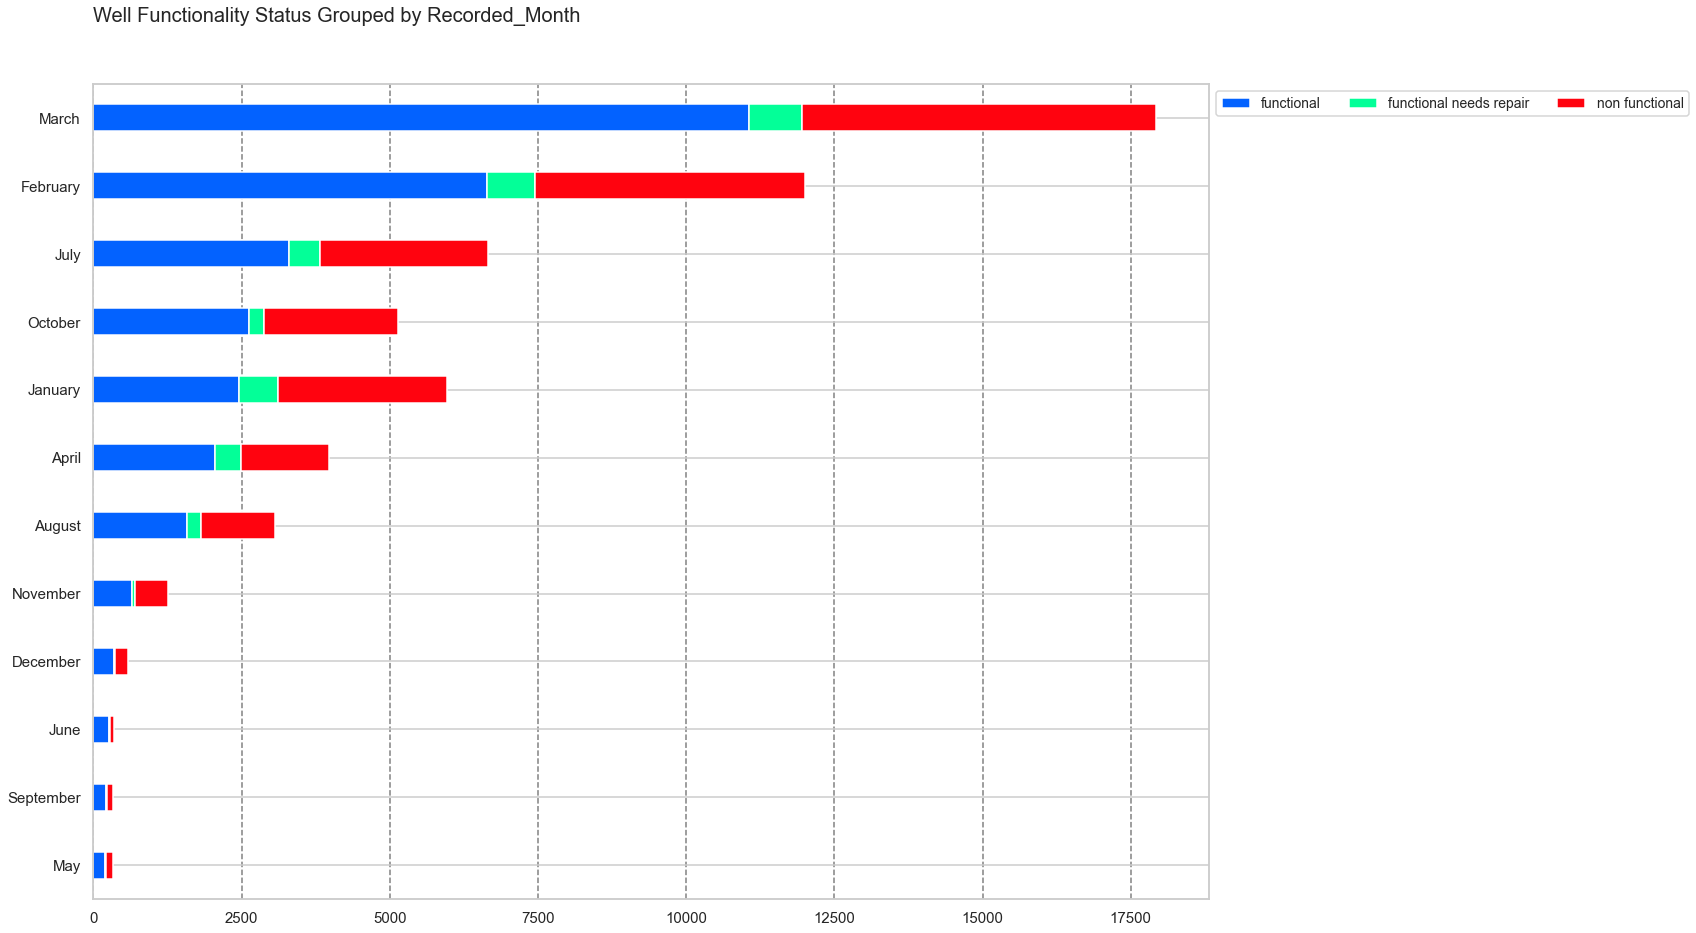

In [74]:
Recorded_month = pd.crosstab(df['Recorded_Month'], df['status_group']).sort_values(by='functional')
title = 'Well Functionality Status Grouped by Recorded_Month\n'
plot_stackedbar(Recorded_month, title, (20,15))

<Axes: ylabel='Recorded_Month'>

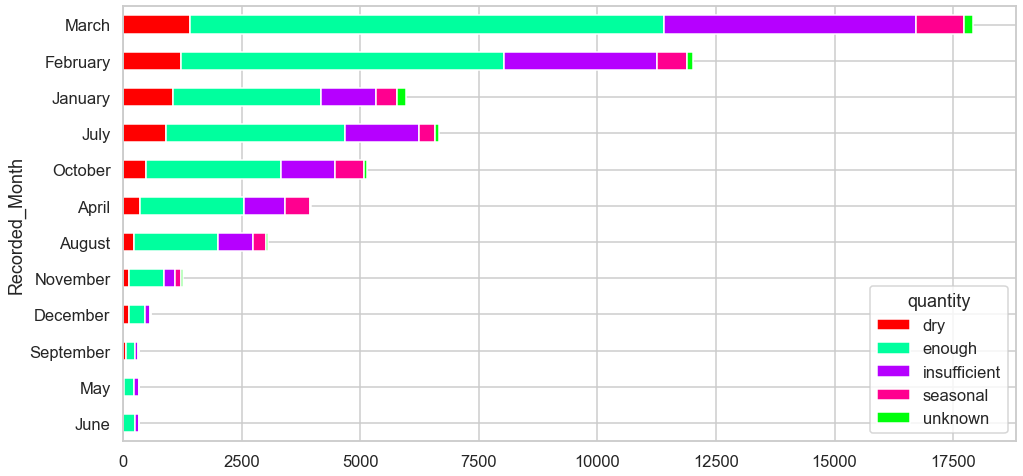

In [75]:
Month_sort = Recorded_Month.sort_values(by = 'dry')
color = ['#FF0000','#00FF9E','#B600FF','#FF008F','#00FF0C']
Month_sort.plot(kind='barh', stacked=True,figsize = (16,8),color = color)

**These Insights are drawn on the basis of recorded dates and according to the data more data records are from March as its a start of Rainy Season in Tanzania**

- Months with higher water availability ("enough" and "seasonal") tend to be March, February, and July. These months demonstrate a positive correlation between sufficient water and a higher proportion of "functional" wells..

- Conversely, months with lower water availability ("dry" and "insufficient") that show a lower count of "functional" wells and higher counts of wells needing repair ("functional needs repair") include October, January, and April.

- Despite water availability, instances of "non functional" wells are relatively consistent across months which indicated that there is lack of maintainence and reparation of well on regular basis.



### Multicorrelation

In [76]:
le =  LabelEncoder()
df['Status_encoded'] = le.fit_transform(df['status_group'])
le.classes_

array(['functional', 'functional needs repair', 'non functional'],
      dtype=object)

- **0 = 'functional'**
- **1 = 'functional needs repair'**
- **2 = 'non functional'**

<Axes: >

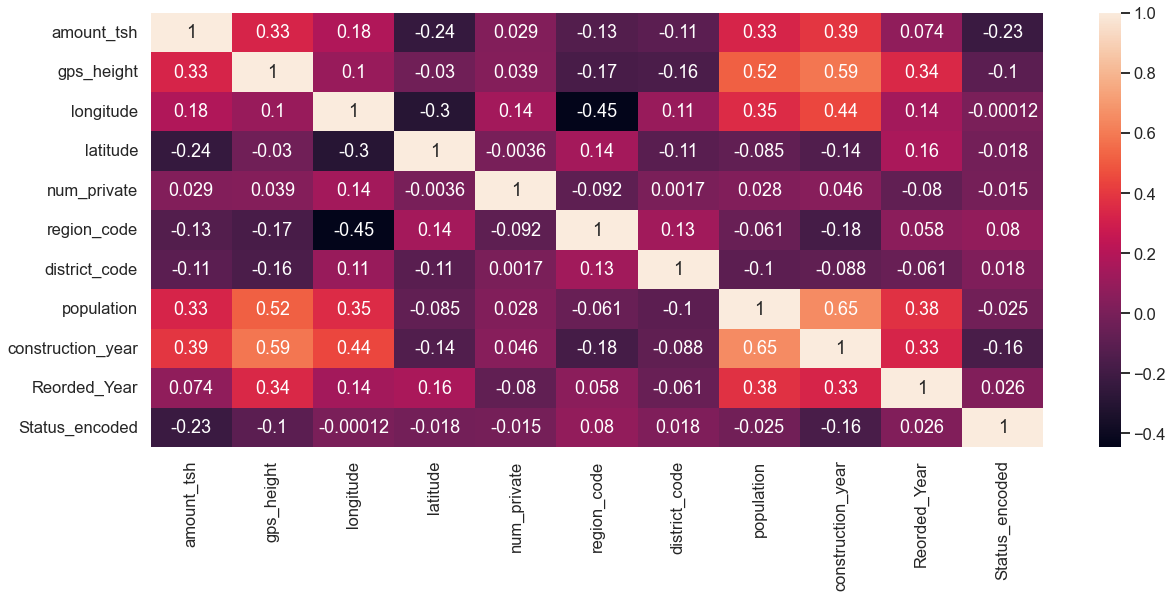

In [77]:
plt.figure(figsize = (20,8))
corr = df.corr(method = 'spearman')
sns.heatmap(corr,annot = True)

-  There is no significant Correlation between the Independent Features.
- gps_height and region_code has high correlation with dependent feature i.e Status_Encoded Comparetively.
- Functionality might be dependent of Altitude of well and Regions of the Country which is also what we commonly interpret.

### Feature Selection

In [78]:
X = data.drop('status_group',axis = 1)
y = data['status_group']

In [79]:
X.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [80]:
column = ['num_private','amount_tsh','construction_year','longitude']

for col in column:
    value = len(X[X[col]==0])/len(df)
    print(f"Missing Values of {col} are {round(value,2)} percent")
    print("*"*20)

Missing Values of num_private are 1.02 percent
********************
Missing Values of amount_tsh are 0.72 percent
********************
Missing Values of construction_year are 0.36 percent
********************
Missing Values of longitude are 0.03 percent
********************


- As more than 70% of the data is Zero is considered as Missing Value in num_private,amount_tsh. We can drop these two columns.
- As with construction_year and Longitude can be imputed with mode of the relevant data.

In [81]:
X.drop(['num_private','amount_tsh'],axis =1,inplace = True)

In [82]:
X.head()

,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


**In the Data Columns that contains similar information:**
- extraction_type,extraction_type_group,extraction_type_class

- payment,payment_type 

- water_quality,quality_group

- quantity,quantity_group

- source,source_type,source_class

- waterpoint_type,waterpoint_type_group

- management,management_group

- region,region_code,district_code,ward,subvillage,lga

- scheme_name,scheme_management,management,

We aim to build a general model that avoids unnecessary complexity and overfitting. Focusing on individual details might lead to too many features, making the model complex and prone to overfitting. Since broader features often include the content of specific columns, using these general features is more straightforward. This approach keeps the model simple while retaining the necessary information for accurate predictions.

**Features containing broader information for model prediction:**
 -  extraction_type_class,
 - payment_type,
 - quality_group,
 - source_class,
 - waterpoint_type_group,
 - management_group
 - scheme_management
 - region 

In [83]:
col_drop = ['extraction_type','extraction_type_group','payment',
            'water_quality','quantity','source','source_type',
            'waterpoint_type','region_code','district_code','ward',
            'subvillage','lga','management','wpt_name','scheme_name','date_recorded','construction_year',
            'recorded_by']
data1 = X.drop(col_drop,axis = 1)

In [84]:
data1.installer.nunique()

2145

In [85]:
data1.funder.nunique()

1897

In [86]:
data1.isnull().sum()/len(data1)

funder                   0.061232
gps_height               0.000000
installer                0.061569
longitude                0.000000
latitude                 0.000000
basin                    0.000000
region                   0.000000
population               0.000000
public_meeting           0.055825
scheme_management        0.065309
permit                   0.051479
extraction_type_class    0.000000
management_group         0.000000
payment_type             0.000000
quality_group            0.000000
quantity_group           0.000000
source_class             0.000000
waterpoint_type_group    0.000000
dtype: float64

In [87]:
data1.head()

,funder,gps_height,installer,longitude,latitude,basin,region,population,public_meeting,scheme_management,permit,extraction_type_class,management_group,payment_type,quality_group,quantity_group,source_class,waterpoint_type_group
0,Roman,1390,Roman,34.938093,-9.856322,Lake Nyasa,Iringa,109,True,VWC,False,gravity,user-group,annually,good,enough,groundwater,communal standpipe
1,Grumeti,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,Mara,280,NaN,Other,True,gravity,user-group,never pay,good,insufficient,surface,communal standpipe
2,Lottery Club,686,World vision,37.460664,-3.821329,Pangani,Manyara,250,True,VWC,True,gravity,user-group,per bucket,good,enough,surface,communal standpipe
3,Unicef,263,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,58,True,VWC,True,submersible,user-group,never pay,good,dry,groundwater,communal standpipe
4,Action In A,0,Artisan,31.130847,-1.825359,Lake Victoria,Kagera,0,True,NaN,True,gravity,other,never pay,good,seasonal,surface,communal standpipe


## Data Splitting

Splitting the Data in to Train and Test from the master data and splitting the train into Validation Set

In [88]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=1012,stratify = y)

In [89]:
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.25, random_state=1012)

#### Imputation of NaN Values

In [90]:
imputer = ColumnTransformer(transformers=[('impute', SimpleImputer(strategy='most_frequent'), 
                                           ['funder', 'installer', 'public_meeting', 
                                                             'scheme_management', 'permit'])],
                            remainder='passthrough')

#### One Hot Encoding and Scaling

In [91]:
def num_cat(data):
    num = []
    cat = []
    for i in data.columns:
        if data[i].dtypes == 'O':
            cat.append(i)
        else:
            num.append(i)
    return num,cat

In [92]:
num_features,cat_features = num_cat(data1)

In [93]:
cat_transformer = Pipeline(steps = [('ohe',OneHotEncoder(drop = 'first',handle_unknown='ignore'))])   

In [94]:
#As Outliers may affect the model
num_transformer = Pipeline(steps= [('scaler',RobustScaler())])

#### Funder & Installer

The Idea is to reduce the number of variables in the installer and funder feature by coverting the variables covering 75% of the data into Major and rest into Minor.Creating a Class and using it in Column Transformer for the pipeline

Inheriting from BaseEstimator allows InstallerFunder class to be compatible with the scikit-learn ecosystem, such as being used within pipelines or grid searches.
Inheriting from TransformerMixin provides the default implementation of fit_transform based on your fit and transform methods, which is often convenient when working with transformers.

In [95]:
class InstallerFunder(BaseEstimator,TransformerMixin):
    
    def transform(self,col):

        value_counts = col.value_counts(normalize=True, ascending=False)

        cumulative_sum =value_counts.cumsum()

        selected_values = cumulative_sum[cumulative_sum <= 0.75].index

        encoded = col.apply(lambda x : 'Major' if x in selected_values else 'Minor')

        return encoded

        def fit(self,col,y=None):
            return self
"""The fit method returns self without performing any actual fitting or computation. 
This can be useful when you want to include your transformer in a pipeline for organizational 
purposes or compatibility, but the transformer itself doesn't require any fitting."""

"The fit method returns self without performing any actual fitting or computation. \nThis can be useful when you want to include your transformer in a pipeline for organizational \npurposes or compatibility, but the transformer itself doesn't require any fitting."

### Preprocessing PipeLine

In [96]:
#Order of the transformation matters as we first convert then encode and scale features
col_trans = ColumnTransformer([('Reduce_var',InstallerFunder(),['funder','installer']),
                                 ('cat_transformer',cat_transformer,cat_features),
                               ('num_transformer',num_transformer,num_features)])

preprocessor = Pipeline(steps = [('imputer',imputer),
                                 ('col_trans',col_trans)])

#### We can see the PipeLine which Functions applies to which column Below

In [97]:
imputer

ColumnTransformer(remainder='passthrough',
                  transformers=[('impute',
                                 SimpleImputer(strategy='most_frequent'),
                                 ['funder', 'installer', 'public_meeting',
                                  'scheme_management', 'permit'])])

In [98]:
col_trans

ColumnTransformer(transformers=[('Reduce_var', InstallerFunder(),
                                 ['funder', 'installer']),
                                ('cat_transformer',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['funder', 'installer', 'basin', 'region',
                                  'public_meeting', 'scheme_management',
                                  'permit', 'extraction_type_class',
                                  'management_group', 'payment_type',
                                  'quality_group', 'quantity_group',
                                  'source_class', 'waterpoint_type_group']),
                                ('num_transformer',
                                 Pipeline(steps=[('scaler', RobustScaler())]),
                                 ['gps_height', 'longitude', 'latitude',
                                  'population'])])

In [99]:
preprocessor

Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['funder', 'installer',
                                                   'public_meeting',
                                                   'scheme_management',
                                                   'permit'])])),
                ('col_trans',
                 ColumnTransformer(transformers=[('Reduce_var',
                                                  InstallerFunder(),
                                                  ['funder', 'installer']),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('ohe',
                                                                   O...
                                                                                 handle_unknown='ignore'))]),
                                                  ['funder', 'installer',
                                                   'basin', 'region',
                                                   'public_meeting',
                                                   'scheme_management',
                                                   'permit',
                                                   'extraction_type_class',
                                                   'management_group',
                                                   'payment_type',
                                                   'quality_group',
                                                   'quantity_group',
                                                   'source_class',
                                                   'waterpoint_type_group']),
                                                 ('num_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['gps_height', 'longitude',
                                                   'latitude',
                                                   'population'])]))])

## Model Building

### Random Forest

In [103]:
rf_pipeline = Pipeline(steps = [('preprocessor',preprocessor),
                               ('Rf',RandomForestClassifier(random_state = 1021))])

#### This Concludes our Analysis of Tanzania Water Wells 

#### Please Refer the Model Report Notebook For Model Building

<img src="Thankyou.jpg" alt="Cover Photo" width="750" height="50" align="center" />